<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span><ul class="toc-item"><li><span><a href="#Технологический-процесс" data-toc-modified-id="Технологический-процесс-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Технологический процесс</a></span></li><li><span><a href="#Параметры-этапов" data-toc-modified-id="Параметры-этапов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Параметры этапов</a></span></li><li><span><a href="#Наименование-признаков" data-toc-modified-id="Наименование-признаков-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Наименование признаков</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Построение-модели" data-toc-modified-id="Построение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Построение модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Оптимизация производства золотодобывающей компании

## Описание проекта

Требуется подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данные находятся в трёх файлах:
* gold_recovery_train.csv — обучающая выборка;
* gold_recovery_test.csv — тестовая выборка;
* gold_recovery_full.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, требуется проверить их на корректность.

Краткий план проекта:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Описание данных
### Технологический процесс
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

### Параметры этапов

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

### Наименование признаков

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
* rougher — флотация;
* primary_cleaner — первичная очистка;
* secondary_cleaner — вторичная очистка;
* final — финальные характеристики;

Возможные значения для блока [тип_параметра]:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

## Подготовка данных

In [1]:
# Отключим предупреждения Anaconda
import warnings

warnings.simplefilter("ignore")

# Будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns

sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

# Увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 8, 5

from math import sqrt

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [2]:
def load_df(name_of_df, separator=",", ind=None, max_rows=89, max_columns=89):
    """Функция загружает датафрэйм и выводит основные данные по нему.
    Аргументы:
    name_of_df - путь к датафрэйму;
    separator - разделитель;
    ind - столбцы для использования в качестве номеров строк;
    max_rows - максимальное число строк, которое будет выведено,
    max_columns - максимальное число столбцов, которое будет выведено"""

    # Считаем и выведем первые 5 строк таблицы
    df = pd.read_csv(name_of_df, sep=separator, index_col=ind)
    print("Выведем первые 5 строк таблицы:", end="\n\n")
    display(df.head())

    # Вывод основных описательных статистик, общей информации о таблице,
    # пропущенных значений, корреляции признаков, количества дубликатов в данных
    print(
        "\n\n\n\nОтобразим основные описательные статистики по признакам:", end="\n\n"
    )
    display(df.describe())
    print("\n\n\n\nПолучим общую информацию о таблице:", end="\n\n")
    display(df.info())
    print(f"\n\n\n\nПропущенные значения по признакам:", end="\n\n")
    pd.set_option("max_rows", max_rows)
    pd.set_option("display.max_columns", max_columns)
    display(pd.DataFrame(df.isnull().sum(), columns=["missing_values"]))
    print(f"\n\n\n\nКорреляция признаков:", end="\n\n")
    display(df.corr())
    print(
        f"\n\n\nКоличество дубликатов в данных:",
        df.duplicated().sum(),
        sep="\n",
        end="\n\n",
    )
    pd.reset_option("max_rows")
    return df

У нас имеется 3 файла формата .csv. Изучим основную информацию о датафрэймах.

In [4]:
gold_recovery_train = load_df(
    "gold_recovery_train.csv"
)

Выведем первые 5 строк таблицы:



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,





Отобразим основные описательные статистики по признакам:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000,16788.000,16490.000,16789.000,15339.000,16794.000,16677.000,16715.000,16794.000,15553.000,15598.000,16860.000,15875.000,16778.000,16502.000,16224.000,16778.000,16777.000,16761.000,16579.000,16777.000,16820.000,16827.000,16820.000,16833.000,16822.000,16833.000,16821.000,16833.000,16833.000,16833.000,16833.000,15618.000,16778.000,16632.000,16347.000,16443.000,16568.000,16777.000,15816.000,16514.000,16237.000,14956.000,16778.000,16778.000,16698.000,16778.000,14287.000,14610.000,16778.000,14611.000,14611.000,16807.000,16807.000,16807.000,16807.000,16807.000,16814.000,16802.000,16809.000,16257.000,16809.000,16802.000,16802.000,16776.000,16764.000,14874.000,16778.000,16497.000,16751.000,16705.000,16748.000,16763.000,16747.000,16752.000,16750.000,16731.000,16747.000,16768.000,16767.000,16775.000,16775.000,16775.000,16776.000,16757.000,16775.000
mean,4.717,9.114,8.301,39.467,67.213,8.757,2.360,9.304,2.688,129.480,8.625,7.297,0.844,7.423,8.620,9.171,29.165,14.917,3.166,6.746,3.591,1521.292,-505.811,1523.880,-507.346,1514.351,-507.094,1468.599,-501.835,-1





Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol              

None





Пропущенные значения по признакам:



,missing_values
date,0
final.output.concentrate_ag,72
final.output.concentrate_pb,72
final.output.concentrate_sol,370
final.output.concentrate_au,71
final.output.recovery,1521
final.output.tail_ag,66
final.output.tail_pb,183
final.output.tail_sol,145
final.output.tail_au,66






Корреляция признаков:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000,0.658,0.705,0.654,-0.089,0.681,0.420,0.509,0.597,0.212,0.293,0.055,0.332,0.742,0.426,0.601,0.527,0.557,0.379,0.565,0.478,0.519,0.493,0.509,0.510,0.540,0.495,0.442,0.460,0.022,-0.010,0.042,0.249,0.702,0.487,0.353,0.119,0.573,0.633,0.219,0.521,0.287,0.179,0.638,0.455,0.531,0.569,0.058,0.166,0.350,0.039,0.096,0.390,0.190,0.457,0.316,0.436,0.302,0.441,0.333,0.461,0.315,0.448,0.330,0.467,0.211,0.436,0.362,0.355,0.414,0.358,0.413,0.387,0.455,0.367,0.473,0.274,0.435,0.244,0.384,0.265,0.523,0.218,0.450,0.380,0.452
final.output.concentrate_pb,0.658,1.000,0.640,0.881,-0.174,0.639,0.624,0.645,0.580,0.375,0.272,0.040,0.234,0.656,0.748,0.501,0.727,0.650,0.482,0.616,0.376,0.578,0.587,0.560,0.608,0.611,0.590,0.455,0.566,0.027,-0.011,0.053,-0.070,0.608,0.672,0.593,0.154,0.759,0.623,0.462,0.649,0.519,0.222,0.577,0.756,0.666,0.679,0.065,-0.089,0.487,-0.164,-0.035,0.418,0.376,0.519,0.346,0.505,0.320,0.485,0.366,0.486,0.332,0.493,0.357,0.590,0.544,0.415,0.358,0.488,0.484,0.475,0.495,0.450,0.460,0.453,0.443,0.330,0.457,0.334,0.488,0.372,0.531,0.313




Количество дубликатов в данных:
0



In [5]:
gold_recovery_test = load_df(
    "gold_recovery_test.csv"
)

Выведем первые 5 строк таблицы:



,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.801,14.993,8.080,1.005,1398.981,-500.226,1399.145,-499.920,1400.103,-500.704,1399.002,-499.485,13.129,5.637,489.794,62.710,42.022,12.084,16.923,6.153,16.868,6.151,1001.849,-350.301,1249.739,-399.108,1249.751,-399.397,1198.288,-399.489,999.472,-399.531,949.566,-398.181,24.938,-500.491,14.948,-500.014,20.018,-450.396,13.987,-449.832,12.024,-497.796,8.017,-501.289,7.947,-432.318,4.873,-500.037,26.706,-499.709
1,2016-09-01 01:59:59,215.392,14.987,8.080,0.990,1398.778,-500.057,1398.055,-499.778,1396.151,-499.240,1399.508,-500.416,13.036,5.526,490.105,61.961,41.188,11.919,17.003,5.999,16.996,6.002,998.691,-350.426,1248.395,-399.946,1249.514,-399.631,1200.506,-399.942,1000.002,-399.492,950.200,-405.788,24.923,-499.814,14.931,-500.764,19.989,-450.114,14.093,-450.059,12.058,-498.696,8.131,-499.634,7.958,-525.840,4.879,-500.162,25.020,-499.819
2,2016-09-01 02:59:59,215.260,12.885,7.787,0.996,1398.494,-500.868,1398.860,-499.765,1398.076,-502.152,1399.497,-499.715,13.138,5.427,489.618,66.904,42.546,12.091,16.993,5.851,16.982,5.854,998.517,-349.784,1247.441,-400.264,1248.207,-401.074,1199.770,-400.791,999.926,-399.237,950.320,-400.864,24.909,-500.304,14.997,-500.994,20.040,-450.263,14.078,-449.661,11.962,-498.767,8.097,-500.827,8.071,-500.802,4.905,-499.829,24.995,-500.623
3,2016-09-01 03:59:59,215.336,12.007,7.640,0.864,1399.618,-498.864,1397.440,-499.211,1400.129,-498.356,1401.065,-501.039,12.401,5.115,476.618,59.866,41.060,12.182,16.532,5.802,16.515,5.804,1000.277,-350.173,1251.323,-398.655,1250.494,-399.747,1199.399,-397.503,1001.931,-400.438,950.735,-399.803,24.894,-499.382,14.917,-499.862,20.031,-449.373,14.014,-449.527,12.033,-498.351,8.075,-499.474,7.897,-500.869,4.931,-499.964,24.949,-498.710
4,2016-09-01 04:59:59,199.099,10.683,7.530,0.806,1401.268,-500.808,1398.129,-499.505,1402.172,-500.811,1399.481,-499.374,11.327,4.767,488.248,63.315,41.269,11.290,13.607,5.738,13.650,5.740,996.541,-350.563,1304.659,-399.512,1306.456,-399.051,1248.699,-400.877,1058.839,-398.988,949.645,-399.278,24.887,-499.357,14.979,-500.187,19.962,-450.639,14.009,-450.022,12.025,-500.786,8.





Отобразим основные описательные статистики по признакам:



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000,5572.000,5856.000,5690.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5816.000,5834.000,5789.000,5840.000,5599.000,5733.000,5801.000,5503.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5836.000,5840.000,5833.000,5840.000,5822.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000
mean,170.515,8.483,7.265,1.321,1481.990,-509.058,1486.909,-511.744,1468.495,-509.741,1486.399,-510.724,8.736,3.553,458.485,55.938,35.106,8.701,13.440,6.170,13.056,6.424,1016.295,-404.978,1270.599,-482.155,1253.495,-480.946,1169.676,-482.152,1018.386,-476.552,962.005,-477.795,25.480,-513.715,21.083,-512.326,24.346,-519.418,20.068,-515.028,15.636,-516.266,13.146,-476.339,12.309,-512.208,9.471,-505.018,16.679,-512.352
std,49.609,3.353,0.612,0.693,310.453,61.339,313.224,67.139,309.981,62.672,313.725,65.418,2.986,1.326,155.958,22.724,10.793,2.803,3.998,1.674,4.534,1.120,226.495,100.954,285.248,55.400,290.703,53.759,285.407,54.968,231.676,67.003,220.862,68.342,5.450,62.448,5.940,63.377,7.951,73.968,7.644,60.458,4.661,62.757,4.304,105.549,3.763,58.865,3.312,68.786,5.405,69.920
min,0.000,0.000,5.650,0.000,0.000,-799.774,0.000,-800.029,0.000,-799.995,0.000,-799.839,0.000,0.000,0.003,0.046,0.000,0.000,0.000,0.000,0.000,0.000,-0.123,-657.950,-0.822,-650.349,-0.282,-650.000,-1.047,-648.391,-2.077,-650.153,-2.593,-650.035,0.000,-799.609,0.000,-798.467,0.000,-799.756,0.000,-809.333,0.000,-799.799,0.000,-800.837,-0.223,-799.661,0.528,-800.220,-0.079,-809.860
25%,143.340,6.411,6.886,0.889,1497.191,-500.455,1497.150,-500.937,1437.050,-501.300,1498.408,-500.554,7.599,3.079,399.782,43.891,33.382,7.764,11.006,5.884,10.999,5.994,998.971,-499.971,1199.501,-500.328,1195.460,-500.311,1004.580,-500.583,998.871,-500.269,900.519,-500.769,24.909,-500.244,19.965,-500.253,22.034,-500.368,15.980,-500.173,12.058,-501.055,11.880,-500.419,10.123,-500.879,7.991,-500.223,13.012,-500.834
50%,176.104,8.023,7.259,1.183,1554.660,-499.997,1553.268,-500.067,1546.161





Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      

None





Пропущенные значения по признакам:



,missing_values
date,0
primary_cleaner.input.sulfate,302
primary_cleaner.input.depressant,284
primary_cleaner.input.feed_size,0
primary_cleaner.input.xanthate,166
primary_cleaner.state.floatbank8_a_air,16
primary_cleaner.state.floatbank8_a_level,16
primary_cleaner.state.floatbank8_b_air,16
primary_cleaner.state.floatbank8_b_level,16
primary_cleaner.state.floatbank8_c_air,16






Корреляция признаков:



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
primary_cleaner.input.sulfate,1.000,0.509,0.121,0.538,0.187,0.179,0.175,0.215,0.144,0.154,0.193,0.086,0.475,0.497,0.571,-0.045,0.543,0.536,0.670,0.659,0.657,0.584,0.275,0.227,-0.081,0.019,-0.102,0.001,-0.121,0.044,-0.100,-0.055,-0.116,-0.008,0.105,0.083,0.276,0.084,0.181,0.114,0.194,0.105,0.330,0.221,0.363,0.123,0.126,0.202,0.186,0.061,-0.073,0.082
primary_cleaner.input.depressant,0.509,1.000,0.200,0.214,0.186,0.235,0.195,0.232,0.107,0.188,0.192,0.073,0.547,0.518,0.275,0.013,0.342,0.520,0.344,0.454,0.341,0.410,0.406,0.146,-0.251,-0.065,-0.263,-0.064,-0.261,-0.027,-0.267,-0.076,-0.280,-0.075,0.103,-0.007,0.251,-0.046,0.295,0.174,0.274,0.168,0.347,0.182,0.268,-0.033,-0.044,0.094,0.104,-0.013,-0.161,0.023
primary_cleaner.input.feed_size,0.121,0.200,1.000,-0.258,-0.017,0.030,-0.017,0.035,-0.029,0.028,-0.020,0.032,0.204,-0.004,0.020,-0.117,0.030,0.127,-0.148,0.135,-0.150,0.135,0.023,-0.205,0.033,0.042,0.048,0.041,0.002,0.060,0.004,0.002,-0.062,0.029,-0.079,0.030,-0.131,0.009,0.024,0.024,-0.010,0.004,-0.109,-0.047,-0.138,-0.108,-0.159,-0.011,-0.189,-0.010,0.032,-0.034
primary_cleaner.input.xanthate,0.538,0.214,-0.258,1.000,0.326,0.222,0.305,0.223,0.264,0.207,0.316,0.131,0.273,0.380,0.553,0.144,0.475,0.318,0.610,0.454,0.656,0.398,0.423,0.450,-0.018,-0.125,-0.050,-0.149,-0.076,-0.139,0.003,-0.184,0.016,-0.162,0.158,0.151,0.325,0.147,0.106,0.174,0.087,0.162,0.397,0.286,0.430,0.237,0.191,0.287,0.195,0.204,-0.046,0.226
primary_cleaner.state.floatbank8_a_air,0.187,0.186,-0.017,0.326,1.000,0.867,0.995,0.770,0.970,0.858,0.992,0.781,0.600,0.514,0.526,0.032,0.595,0.619,0.167,0.407,0.514,0.239,0.802,0.399,0.795,0.603,0.774,0.573,0.735,0.534,0.815,0.526,0.799,0.523,0.748,0.798,0.723,0.719,0.631,0.666,0.595,0.579,0.733,0.771,0.690,0.524,0.675,0.868,0.606,0.751,0.624,0.759
primary_cleaner.state.floatbank8_a_level,0.179,0.235,0.030,0.222,0.867,1.000,0.862,0.868,0.838,0.967,0.860,0.869,0.610,0.576,0.546,0.056,0.641,0.637,0.116,0.419,0.494,0.190,0.826,0.466,0.732,0.516,0.690,0.475,0.657,0.450,0.714,0.428,0.720,0.428,0.704,0.817,0.653,0.755,0.551,0.699,0.473,0.590,0.656,0.782,0.583,0.541,0.545,0.846,0.465,0.722,0




Количество дубликатов в данных:
0



In [6]:
gold_recovery_full = load_df(
    "gold_recovery_full.csv"
)

Выведем первые 5 строк таблицы:



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,





Отобразим основные описательные статистики по признакам:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000,22629.000,22331.000,22630.000,20753.000,22633.000,22516.000,22445.000,22635.000,21107.000,21170.000,22716.000,21565.000,22618.000,22268.000,21918.000,22618.000,22614.000,22594.000,22365.000,22617.000,22660.000,22667.000,22660.000,22673.000,22662.000,22673.000,22661.000,22673.000,22672.000,22672.000,22672.000,21089.000,22618.000,22472.000,22163.000,22277.000,22357.000,22617.000,21415.000,22247.000,22038.000,20459.000,22618.000,22618.000,22526.000,22618.000,19597.000,19979.000,22618.000,19980.000,19980.000,22646.000,22647.000,22646.000,22647.000,22646.000,22654.000,22641.000,22649.000,22096.000,22649.000,22641.000,22642.000,22616.000,22600.000,20501.000,22618.000,22333.000,22591.000,22538.000,22588.000,22585.000,22587.000,22592.000,22590.000,22571.000,22587.000,22608.000,22607.000,22615.000,22615.000,22615.000,22616.000,22597.000,22615.000
mean,4.782,9.095,8.640,40.001,67.447,8.924,2.488,9.524,2.827,140.278,8.588,7.289,0.970,7.692,8.921,9.574,29.212,14.876,3.176,7.208,3.670,1511.163,-506.648,1514.352,-508.479,1502.534,-507.776,1473.186,-504.125,-6





Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol              

None





Пропущенные значения по признакам:



,missing_values
date,0
final.output.concentrate_ag,89
final.output.concentrate_pb,87
final.output.concentrate_sol,385
final.output.concentrate_au,86
final.output.recovery,1963
final.output.tail_ag,83
final.output.tail_pb,200
final.output.tail_sol,271
final.output.tail_au,81






Корреляция признаков:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000,0.652,0.700,0.646,0.010,0.675,0.424,0.490,0.578,0.219,0.275,0.040,0.274,0.720,0.418,0.593,0.489,0.539,0.377,0.538,0.441,0.479,0.458,0.474,0.469,0.497,0.456,0.426,0.419,0.152,-0.007,0.039,0.212,0.686,0.490,0.333,0.092,0.541,0.621,0.205,0.498,0.284,0.204,0.622,0.440,0.510,0.542,0.099,0.184,0.324,0.025,0.096,0.363,0.145,0.413,0.306,0.397,0.293,0.396,0.318,0.411,0.300,0.394,0.307,0.458,0.189,0.429,0.343,0.323,0.387,0.330,0.384,0.345,0.402,0.337,0.425,0.251,0.389,0.240,0.304,0.232,0.475,0.193,0.398,0.350,0.410
final.output.concentrate_pb,0.652,1.000,0.605,0.873,-0.056,0.597,0.611,0.635,0.535,0.314,0.268,-0.010,0.226,0.615,0.729,0.473,0.690,0.619,0.472,0.566,0.346,0.535,0.551,0.520,0.567,0.563,0.551,0.437,0.525,0.182,-0.007,0.051,-0.123,0.558,0.646,0.572,0.156,0.727,0.579,0.440,0.596,0.504,0.209,0.539,0.735,0.640,0.638,0.085,-0.189,0.466,-0.138,-0.104,0.403,0.375,0.467,0.315,0.451,0.289,0.432,0.325,0.440,0.293,0.453,0.309,0.571,0.540,0.372,0.339,0.462,0.459,0.454,0.466,0.405,0.440,0.394,0.431,0.326,0.442,0.332,0.438,0.350,0.503,0.304




Количество дубликатов в данных:
0



Обучающая выборка состоит из 87 столбцов (признаков) и 16 860 строк (объектов). Тестовая выборка содержит 53 признака, а также 5856 объектов. Полные исходные данные включают в себя 87 столбцов и 22716 строк.

Как было отмечено ранее, некоторые значения пропущены, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Попробуем избавиться от пропусков с помощью интерполяции, т.к. соседние по времени параметры часто похожи.

Для начала проверим, что эффективность обогащения чернового концентрата рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Эффективность обогащения рассчитывается по формуле:

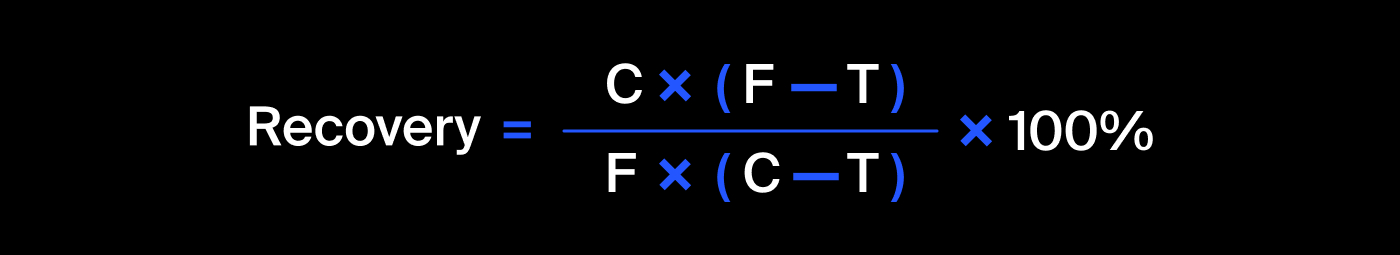

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [12]:
gold_recovery_train.filter(regex="^primary_cleaner(.*)_au$", axis=1)

,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_au
0,34.174,2.107
1,34.119,2.353
2,33.969,2.417
3,28.261,2.262
4,33.045,2.277
...,...,...
16855,32.940,2.314
16856,32.925,2.463
16857,31.857,2.612
16858,30.771,2.801


Для признака признака rougher.output.recovery формула примет вид:

$$rougher.output.recovery=\frac{rougher.output.concentrate\_au*(rougher.input.feed\_au-rougher.output.tail\_au)}{rougher.input.feed\_au*(rougher.output.concentrate\_au-rougher.output.tail\_au)}*100\%$$

In [13]:
mae = abs(
    gold_recovery_train["rougher.output.recovery"]
    - (
        (
            gold_recovery_train["rougher.output.concentrate_au"]
            * (
                gold_recovery_train["rougher.input.feed_au"]
                - gold_recovery_train["rougher.output.tail_au"]
            )
        )
        / (
            gold_recovery_train["rougher.input.feed_au"]
            * (
                gold_recovery_train["rougher.output.concentrate_au"]
                - gold_recovery_train["rougher.output.tail_au"]
            )
        )
        * 100
    )
).sum() / len(gold_recovery_train["rougher.output.recovery"])

mae

8.00350954615662e-15

Значение MAE практически равно нулю, а значит, рассчитанные нами значения rougher.output.recovery и те, что были в соответствующем столбец практически совпадают.

Проанализируем признаки в тестовой выборке и посмотрим, какие параметры в ней недоступны, но имеются в тренировочной выборке, а также к какому типу они относятся. В тренировочной выборке содержится 87 признаков, а в тестовой - 53 признака, т.е. разница составляет 34.

In [14]:
def is_different(df1, df2):
    columns = []
    for column in df1.columns:
        if column not in df2.columns:
            columns.append(column)
    print(
        f"Количество колонок, которые присутствуют в первом датасэте и отсутствуют во втором составляет: {len(columns)}",
        end="\n\n",
    )
    return columns

In [15]:
is_different(gold_recovery_train, gold_recovery_test)

Количество колонок, которые присутствуют в первом датасэте и отсутствуют во втором составляет: 34



['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Мы видим, что в тестовой выборке отсутствуют признаки с параметром output, т.е. с параметром продукта на всех этапах: флотация, первичная очистка, вторичная очистка, финальные харктеристики.

Выполним предобработку данных: попробуем избавиться от пропущенных значений. Следует вспомнить, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Воспользуемся этим, и выполним заполнение пропущенных значений с помощью интерполяции, а первые и последние пропущенные значения можно заполнить с помощью .fillna(method=‘bfill’), .fillna(method=‘ffill’) соответственно.

In [16]:
def impute_missing_values(df):
    print(
        f"Имеются пропущенные значения до обработки в признаках: {df.isnull().sum()[df.isnull().sum() > 0]}",
        end="\n\n",
    )
    df = df.interpolate()
    if len(df.isnull().sum()[df.isnull().sum() > 0]) > 0:
        df = df.fillna(method="ffill")
    if len(df.isnull().sum()[df.isnull().sum() > 0]) > 0:
        df = df.fillna(method="bfill")
    print(
        f"Остались пропущенные значения после обработки в признаках: {df.isnull().sum()[df.isnull().sum() > 0]}"
    )
    return df

In [17]:
gold_recovery_train = impute_missing_values(gold_recovery_train)

Имеются пропущенные значения до обработки в признаках: final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 85, dtype: int64

Остались пропущенные значения после обработки в признаках: Series([], dtype: int64)


In [18]:
gold_recovery_test = impute_missing_values(gold_recovery_test)

Имеются пропущенные значения до обработки в признаках: primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate           

In [19]:
gold_recovery_full = impute_missing_values(gold_recovery_full)

Имеются пропущенные значения до обработки в признаках: final.output.concentrate_ag                     89
final.output.concentrate_pb                     87
final.output.concentrate_sol                   385
final.output.concentrate_au                     86
final.output.recovery                         1963
                                              ... 
secondary_cleaner.state.floatbank5_a_level     101
secondary_cleaner.state.floatbank5_b_air       101
secondary_cleaner.state.floatbank5_b_level     100
secondary_cleaner.state.floatbank6_a_air       119
secondary_cleaner.state.floatbank6_a_level     101
Length: 85, dtype: int64

Остались пропущенные значения после обработки в признаках: Series([], dtype: int64)


### Вывод

Мы провели этап подготовки данных: загрузили тренировочный, тестовый и датасэт с полными данными. На этапе подготовки данных мы выполнили следующие шаги:

* Проверили, что эффективность обогащения рассчитана правильно, т.к. MAE получилась близкой к нулю;
* Выяснили, что в тестовом датасэте отсутствуют 34 признака с параметром output, т.е. с параметром продукта;
* Избавились от пропусков с помощью интерполяции.

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

С технологической точки зрения бывают 3 этапа очистки сырья:
* флотация;
* первичная очистка;
* вторичная очистка.

Значения признаков непрерывны, поэтому необходимо строить графики плотностей (density) распределения.

In [20]:
def compare_distribution(df, columns):
    f, ax = plt.subplots(ncols=2, figsize=(20, 8))
    sns.kdeplot(data=df[columns], shade=1, ax=ax[0])
    metal = columns[1].split(".")[-1]
    if metal == "concentrate_au":
        ax[0].set(xlabel="Концентрация золота", ylabel="Плотность распределения")
        ax[0].set_title("Сравнение распределений концентрации золота на разных этапах")
        ax[1].set(ylabel="Концентрация золота")
        ax[1].set_title("Боксплоты концентрации золота на разных этапах")
    elif metal == "tail_au":
        ax[0].set(
            xlabel="Концентрация золота в отвальных хвостах",
            ylabel="Плотность распределения",
        )
        ax[0].set_title(
            "Сравнение распределений концентрации золота в отвальных хвостах на разных этапах"
        )
        ax[1].set(ylabel="Концентрация золота в отвальных хвостах")
        ax[1].set_title(
            "Боксплоты концентрации золота в отвальных хвостах на разных этапах"
        )
    elif metal == "concentrate_ag":
        ax[0].set(xlabel="Концентрация серебра", ylabel="Плотность распределения")
        ax[0].set_title("Сравнение распределений концентрации серебра на разных этапах")
        ax[1].set(ylabel="Концентрация серебра")
        ax[1].set_title("Боксплоты концентрации серебра на разных этапах")
    elif metal == "tail_ag":
        ax[0].set(
            xlabel="Концентрация серебра в отвальных хвостах",
            ylabel="Плотность распределения",
        )
        ax[0].set_title(
            "Сравнение распределений концентрации серебра в отвальных хвостах на разных этапах"
        )
        ax[1].set(ylabel="Концентрация серебра в отвальных хвостах")
        ax[1].set_title(
            "Боксплоты концентрации серебра в отвальных хвостах на разных этапах"
        )
    elif metal == "concentrate_pb":
        ax[0].set(xlabel="Концентрация свинца", ylabel="Плотность распределения")
        ax[0].set_title("Сравнение распределений концентрации свинца на разных этапах")
        ax[1].set(ylabel="Концентрация свинца")
        ax[1].set_title("Боксплоты концентрации свинца на разных этапах")
    else:
        ax[0].set(
            xlabel="Концентрация свинца в отвальных хвостах",
            ylabel="Плотность распределения",
        )
        ax[0].set_title(
            "Сравнение распределений концентрации свинца в отвальных хвостах на разных этапах"
        )
        ax[1].set(ylabel="Концентрация свинца в отвальных хвостах")
        ax[1].set_title(
            "Боксплоты концентрации свинца в отвальных хвостах на разных этапах"
        )
    sns.boxplot(data=df[columns], ax=ax[1])
    ax[1].set_xlabel("Этапы обработки", fontsize=12)
    display(df[columns].describe())
    f.show()

Сравним концентрацию золота в сырье и продукте в зависимости от этапа обработки.

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,22716.000,22716.000,22716.000
mean,17.824,29.113,39.891
std,6.848,10.652,13.531
min,0.000,0.000,0.000
25%,17.891,29.333,42.350
50%,19.994,32.344,44.639
75%,21.561,34.760,46.107
max,28.825,45.934,53.611


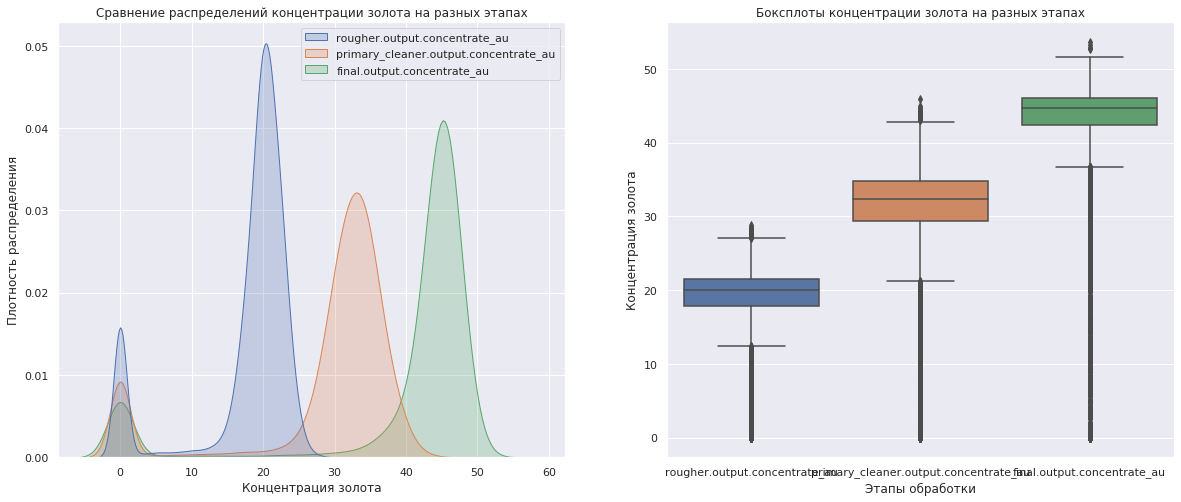

In [17]:
compare_distribution(
    gold_recovery_full,
    [
        "rougher.output.concentrate_au",
        "primary_cleaner.output.concentrate_au",
        "final.output.concentrate_au",
    ],
)

Мы видим, что концентрация золота возрастает на каждом этапе очистки, а число объектов, где доля золота равна нулю уменьшается. Это ожидаемый результат, т.к. нам необходимо получить золото из руды. После флотации медианное значение концентрации золота равно 19,994 после первичной очистки - 32,344, после вторичной очистки - 44,639.

Проанализируем концентрацию золота в отвальных хвостах в зависимости от этапа.

,rougher.output.tail_au,primary_cleaner.output.tail_au,secondary_cleaner.output.tail_au,final.output.tail_au
count,22716.000,22716.000,22716.000,22716.000
mean,1.908,3.659,4.027,2.820
std,0.828,1.992,2.610,1.269
min,0.021,0.000,0.000,0.000
25%,1.442,2.731,2.859,2.297
50%,1.848,3.509,3.949,2.910
75%,2.273,4.556,5.004,3.552
max,9.689,18.529,26.812,9.790


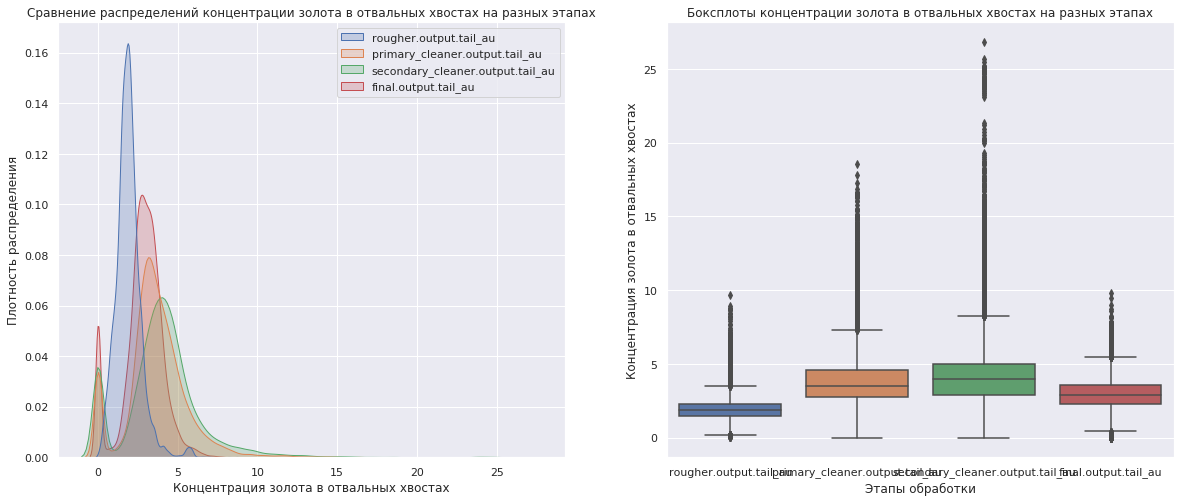

In [18]:
compare_distribution(
    gold_recovery_full,
    [
        "rougher.output.tail_au",
        "primary_cleaner.output.tail_au",
        "secondary_cleaner.output.tail_au",
        "final.output.tail_au",
    ],
)

Концентрация золота в отвальных хвостах существенно ниже, чем в пригодном для дальнейших этапов продукте, однако, мы также наблюдаем логичное повышение концентрации от одного этапа к другому. Так, например, после флотации медианное значение концентрации золота в отвальных хвостах равно 1,848 после первичной очистки - 3,509, после вторичной очистки - 3,949, а на финальной стадии - 2,910.

Посмотрим на концентрации серебра в сырье и продукте в зависимости от этапа обработки.

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,22716.000,22716.000,22716.000
mean,10.841,7.665,4.769
std,4.410,3.135,2.041
min,0.000,0.000,0.000
25%,10.107,6.755,4.011
50%,11.774,8.256,4.950
75%,13.610,9.690,5.858
max,24.480,16.082,16.002


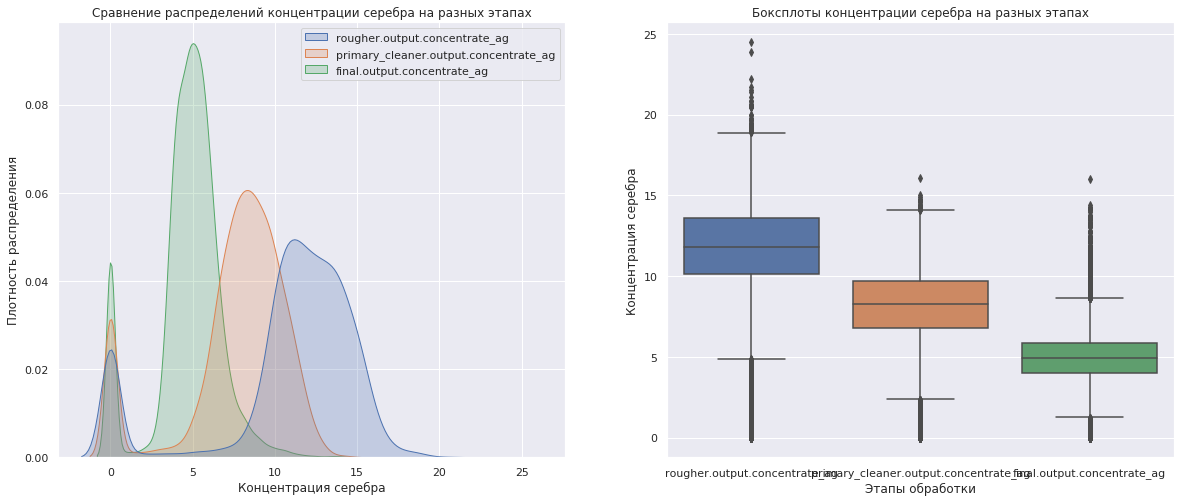

In [19]:
compare_distribution(
    gold_recovery_full,
    [
        "rougher.output.concentrate_ag",
        "primary_cleaner.output.concentrate_ag",
        "final.output.concentrate_ag",
    ],
)

Концентрация серебра уменьшается на каждом этапе очистки, как и число объектов, где доля серебра равна нулю. После флотации медианное значение концентрации серебра равно 11,774 после первичной очистки - 8,256, после вторичной очистки - 4,950.

Сравним концентрации серебра в хвостах в зависимости от этапа обработки.

,rougher.output.tail_ag,primary_cleaner.output.tail_ag,secondary_cleaner.output.tail_ag,final.output.tail_ag
count,22716.000,22716.000,22716.000,22716.000
mean,5.615,14.832,13.334,8.901
std,1.160,5.701,5.803,3.542
min,0.595,0.000,0.000,0.000
25%,4.880,13.441,11.772,7.668
50%,5.747,15.589,15.201,9.475
75%,6.405,17.920,17.223,11.083
max,12.719,29.460,23.265,19.552


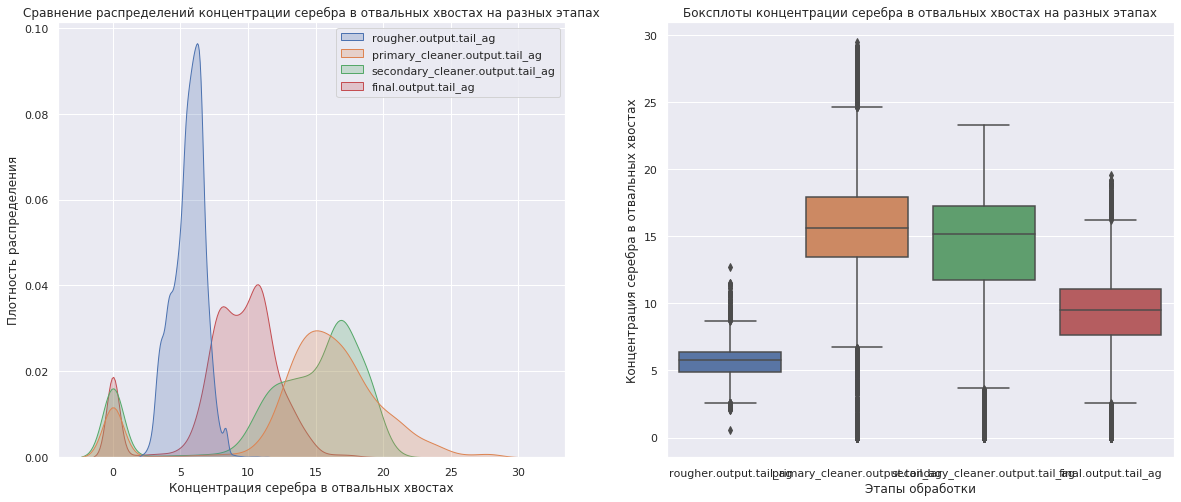

In [20]:
compare_distribution(
    gold_recovery_full,
    [
        "rougher.output.tail_ag",
        "primary_cleaner.output.tail_ag",
        "secondary_cleaner.output.tail_ag",
        "final.output.tail_ag",
    ],
)

После флотации медианное значение концентрации серебра в отвальных хвостах равно 5,747 после первичной очистки - 15,589, после вторичной очистки - 15,201, а в финальной стадии - 9,475, т.е. какой-то определенной и ярковыраженной тенденции увеличения или уменьшения нет.

Выполним сравнение концентрации свинца в сырье и продукте в зависимости от этапа.

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,22716.000,22716.000,22716.000
mean,6.882,8.820,9.071
std,2.827,3.763,3.258
min,0.000,0.000,0.000
25%,6.362,7.618,8.735
50%,7.569,9.876,9.907
75%,8.476,11.231,10.925
max,18.394,17.081,17.032


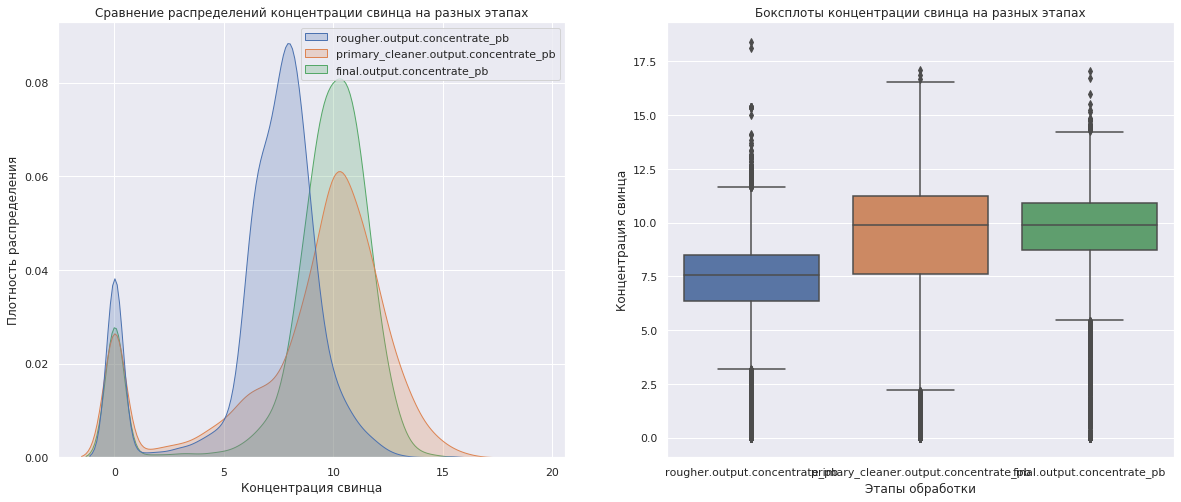

In [21]:
compare_distribution(
    gold_recovery_full,
    [
        "rougher.output.concentrate_pb",
        "primary_cleaner.output.concentrate_pb",
        "final.output.concentrate_pb",
    ],
)

 После флотации медианное значение концентрации свинца равно 7,569 после первичной очистки оно возрастает и равно 9,876, после вторичной очистки - 9,907.

Выполним сравнение концентрации свинца в отвальных хвостах в зависимости от этапа.

,rougher.output.tail_pb,primary_cleaner.output.tail_pb,secondary_cleaner.output.tail_pb,final.output.tail_pb
count,22716.000,22716.000,22716.000,22716.000
mean,0.592,3.165,5.287,2.471
std,0.316,1.659,3.099,1.200
min,0.000,0.000,0.000,0.000
25%,0.426,2.259,3.433,1.780
50%,0.589,3.149,5.060,2.644
75%,0.763,4.118,7.577,3.282
max,3.778,9.635,17.043,6.087


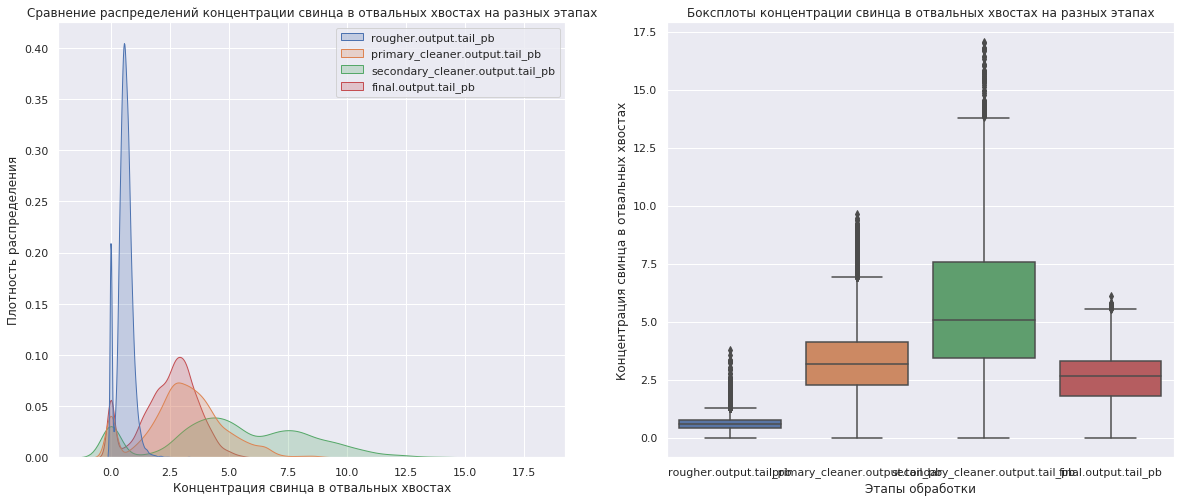

In [22]:
compare_distribution(
    gold_recovery_full,
    [
        "rougher.output.tail_pb",
        "primary_cleaner.output.tail_pb",
        "secondary_cleaner.output.tail_pb",
        "final.output.tail_pb",
    ],
)

В отвальных хвостах концентрация свинца увеличивается включительно до этапа вторичной очистки, после чего уменьшается. На этапе флотации медианное значение концентрации свинца в отвальных хвостах составляет 0,589, после первичной обработки - 3,149, после вторичной - 5,060, а в финальной стадии - 2,644.

Теперь сравним размеры гранул (feed size) на обучающей и тестовой выборках. По условию, распределения не должны принципиально отличаться. Найдём нужные для анализа признаки с помощью метода .filter().

In [21]:
print(gold_recovery_train.filter(regex="^rougher(.*)size$", axis=1).columns)
print(gold_recovery_test.filter(regex="^rougher(.*)size$", axis=1).columns)

Index(['rougher.input.feed_size'], dtype='object')
Index(['rougher.input.feed_size'], dtype='object')


Сравним признаки rougher.input.feed_size (размер гранул сырья)  на тренировочной и тестовой выборках. Кроме того, используем статистические тесты: U критерий Манна-Уитни (непараметрический аналог t-test, который не требует нормальности распределения), а также критерий согласия Колмогорова-Смирнова, который предназначен для проверки гипотезы о принадлежности выборки некоторому закону распределения, то есть проверки того, что эмпирическое распределение соответствует предполагаемой модели.

In [22]:
def test_distribution(distrib1, distrib2, alpha=0.05):
    f, ax = plt.subplots(figsize=(20, 8))
    sns.kdeplot(data=distrib1, shade=1)
    sns.kdeplot(data=distrib2, shade=1)
    ax.set(xlabel="Размер гранул", ylabel="Плотность распределения")
    ax.set_title("Размер гранул сырья")

    stat_mann, p_mann = mannwhitneyu(distrib1, distrib2, alternative="two-sided")
    stat_ks, p_ks = ks_2samp(distrib1, distrib2, alternative="two-sided")
    print(
        "Значение статистики U критерия Манна-Уитни = %.3f, p.value=%.3f"
        % (stat_mann, p_mann)
    )
    if p_mann > alpha:
        print(
            "Распределения согласно U критерию Манна-Уитни одинаковы (не удалось отклонить H0)"
        )
    else:
        print("Распределения согласно U критерию Манна-Уитни отличаются (отклоняем H0)")
    print(
        "Значение статистики критерия согласия Колмогорова-Смирнова = %.3f, p.value=%.3f"
        % (stat_ks, p_ks)
    )
    if p_ks > alpha:
        print(
            "Распределения согласно критерию Колмогорова-Смирнова одинаковы (не удалось отклонить H0)"
        )
    else:
        print(
            "Распределения согласно критерию Колмогорова-Смирнова отличаются (отклоняем H0)"
        )

Значение статистики U критерия Манна-Уитни = 56713508.000, p.value=0.000
Распределения согласно U критерию Манна-Уитни отличаются (отклоняем H0)
Значение статистики критерия согласия Колмогорова-Смирнова = 0.187, p.value=0.000
Распределения согласно критерию Колмогорова-Смирнова отличаются (отклоняем H0)


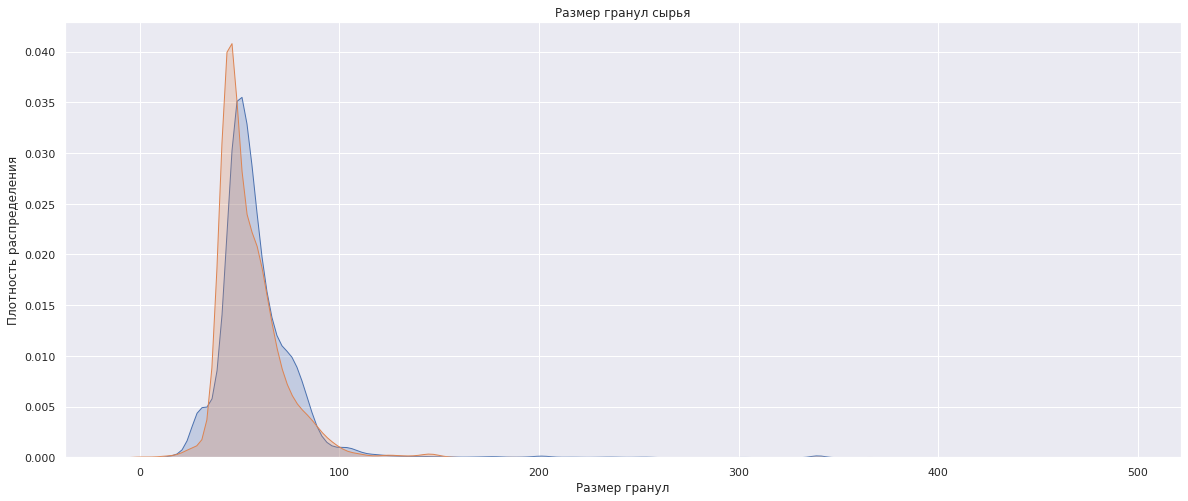

In [25]:
test_distribution(
    gold_recovery_train["rougher.input.feed_size"],
    gold_recovery_test["rougher.input.feed_size"],
)

Несмотря на визуальное сходство, оба статистических теста сигнализируют о том, что распределения размера гранул сырья для тренировочной и тестовой выборок не схожи. Тем не менее, в данном случае мы можем рассчитывать на адекватность модели, т.к. совпадают пиковые значения, а также общее визуальное представление распределений.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Для каждого этапа необходимо сложить ag, au, sol, pb и удалить суммарные значения, которые меньше 0 или выше 100.

In [23]:
def delete_anomaly(train_test_lst_of_df, lst_train_data_plot, lst_test_data_plot):
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    for train_data in lst_train_data_plot:
        sns.kdeplot(data=train_data, shade=1, ax=ax[0][0])
        train_test_lst_of_df[0] = train_test_lst_of_df[0][
            (train_data > 0.05) & (train_data <= 100)
        ]
        sns.kdeplot(
            data=train_data[(train_data > 0.05) & (train_data <= 100)],
            shade=1,
            ax=ax[1][0],
        )
    for test_data in lst_test_data_plot:
        sns.kdeplot(data=test_data, shade=1, ax=ax[0][1])
        train_test_lst_of_df[1] = train_test_lst_of_df[1][
            (test_data > 0.05) & (test_data <= 100)
        ]
        sns.kdeplot(
            data=test_data[(test_data > 0.05) & (test_data <= 100)],
            shade=1,
            ax=ax[1][1],
        )

    ax[0][0].set(
        xlabel="Суммарная концентрация ag, au, sol, pb на разных этапах",
        ylabel="Плотность распределения",
    )
    ax[0][0].set_title(
        "Распределение концентраций на тренировочной выборке до удаления аномальных значений"
    )
    ax[0][1].set(
        xlabel="Суммарная концентрация ag, au, sol, pb",
        ylabel="Плотность распределения",
    )
    ax[0][1].set_title(
        "Распределение концентраций на тестовой выборке до удаления аномальных значений"
    )
    ax[1][0].set(
        xlabel="Суммарная концентрация ag, au, sol, pb на разных этапах",
        ylabel="Плотность распределения",
    )
    ax[1][0].set_title(
        "Распределение концентраций на тренировочной выборке после удаления аномальных значений"
    )
    ax[1][1].set(
        xlabel="Суммарная концентрация ag, au, sol, pb",
        ylabel="Плотность распределения",
    )
    ax[1][1].set_title(
        "Распределение концентраций на тестовой выборке после удаления аномальных значений"
    )
    ax[0][0].legend(
        [
            "rougher.input.feed",
            "rougher.output.concentrate",
            "primary_cleaner.output.concentrate",
            "final.output.concentrate",
        ],
        loc=2,
    )
    ax[0][1].legend(["rougher.input.feed"], loc=2)
    ax[1][0].legend(
        [
            "rougher.input.feed",
            "rougher.output.concentrate",
            "primary_cleaner.output.concentrate",
            "final.output.concentrate",
        ],
        loc=2,
    )
    ax[1][1].legend(["rougher.input.feed"], loc=2)
    return train_test_lst_of_df

Создадим два списка train_concentration, test_concentration и запишем в них концентрации ag, au, sol, pb на разных этапах обработки для тренировочной и тестовой выборки соответственно, после чего передадим их в функцию.

In [24]:
rougher_input_feed_train = (
    gold_recovery_train["rougher.input.feed_ag"]
    + gold_recovery_train["rougher.input.feed_au"]
    + gold_recovery_train["rougher.input.feed_sol"]
    + gold_recovery_train["rougher.input.feed_pb"]
)

rougher_output_concentrate_train = (
    gold_recovery_train["rougher.output.concentrate_ag"]
    + gold_recovery_train["rougher.output.concentrate_au"]
    + gold_recovery_train["rougher.output.concentrate_sol"]
    + gold_recovery_train["rougher.output.concentrate_pb"]
)

primary_cleaner_output_concentrate_train = (
    gold_recovery_train["primary_cleaner.output.concentrate_ag"]
    + gold_recovery_train["primary_cleaner.output.concentrate_au"]
    + gold_recovery_train["primary_cleaner.output.concentrate_sol"]
    + gold_recovery_train["primary_cleaner.output.concentrate_pb"]
)

final_output_concentrate_train = (
    gold_recovery_train["final.output.concentrate_ag"]
    + gold_recovery_train["final.output.concentrate_au"]
    + gold_recovery_train["final.output.concentrate_sol"]
    + gold_recovery_train["final.output.concentrate_pb"]
)

train_concentration = [
    rougher_input_feed_train,
    rougher_output_concentrate_train,
    primary_cleaner_output_concentrate_train,
    final_output_concentrate_train,
]

In [25]:
rougher_input_feed_test = (
    gold_recovery_test["rougher.input.feed_ag"]
    + gold_recovery_test["rougher.input.feed_au"]
    + gold_recovery_test["rougher.input.feed_sol"]
    + gold_recovery_test["rougher.input.feed_pb"]
)

test_concentration = [rougher_input_feed_test]

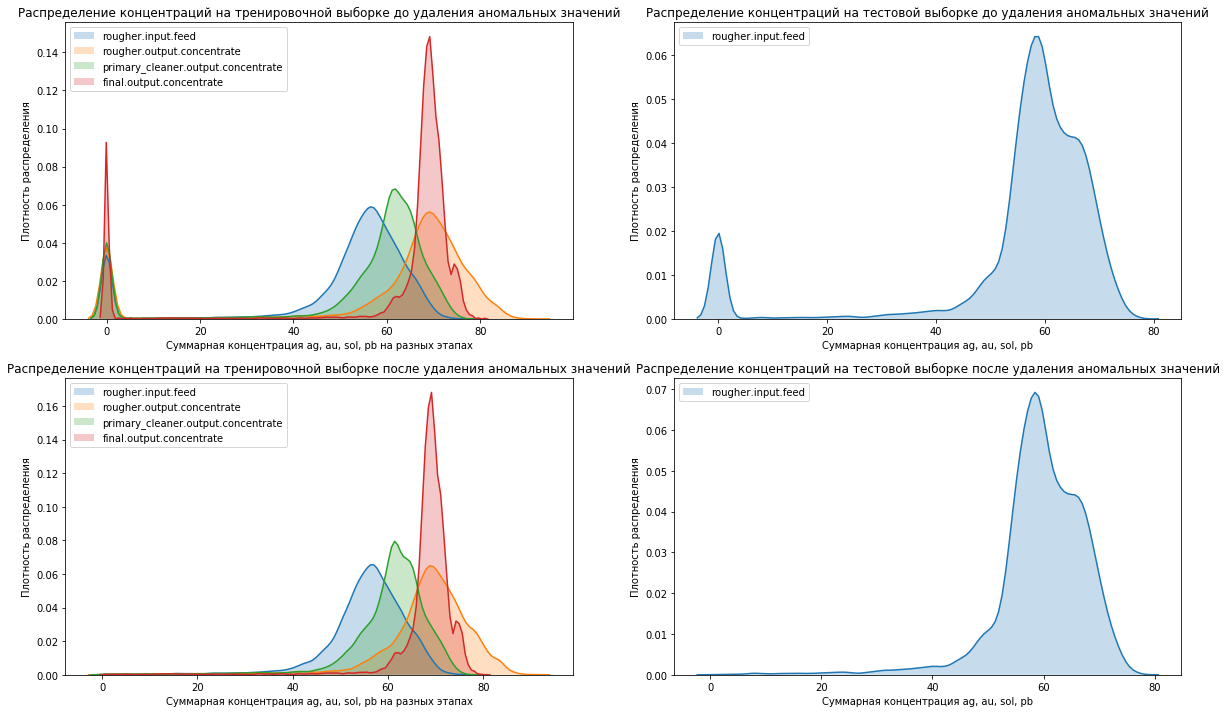

In [28]:
gold_recovery_train_cleared, gold_recovery_test_cleared = delete_anomaly(
    [gold_recovery_train, gold_recovery_test], train_concentration, test_concentration
)

Мы избавились от аномально низких значений на тренировочном и тестовом датасэтах.

### Вывод

На этапе анализа данных мы выяснили, что концентрация золота и серебра возрастает от этапа к этапу, а число отвальных хвостов на каждом следующем этапе убывает.

Критерий согласия Колмогорова-Смирнова показал, что распределения размеров гранул на обучающей и тестовой выборке различны, однако, с визуальной точки зрения, можно считать распределения равными.

С помощью визуализации мы выявили и избавились от аномальных значений: присутствовали объекты, где суммарная концентрация золота, серебра, солей и свинца была равна нулю.

## Построение модели

Предсказание коэффициента восстановления золота из золотосодержащей руды - задача регрессии. Прежде чем применить модель машинного обучения, подготовим данные. Для этого можем попробовать использовать несколько подходов: логарифмирование значений признаков, стандартизацию, нормализацию, а также преобразование с помощью алгоритма RobustScaler. В случе применения алгоритмов, основанных на деревьях решений, такие преобразования не принесут результатов, однако в случае с линейной регрессией, это может в значительной степени повысить метрики линейной регрессии.

In [29]:
gold_recovery_train_cleared.set_index("date", inplace=True)

In [30]:
gold_recovery_test_cleared.set_index("date", inplace=True)

In [31]:
gold_recovery_full.set_index("date", inplace=True)

Напишем функцию метрики sMAPE. Обратим внимание, что в случае идеально точных предсказаний значение метрики должно стремиться к нулю. После написания функции воспользуемся make_scorer, после чего функцию оценки можно будет передавать в качестве оценщика для подбора наилучших параметров.

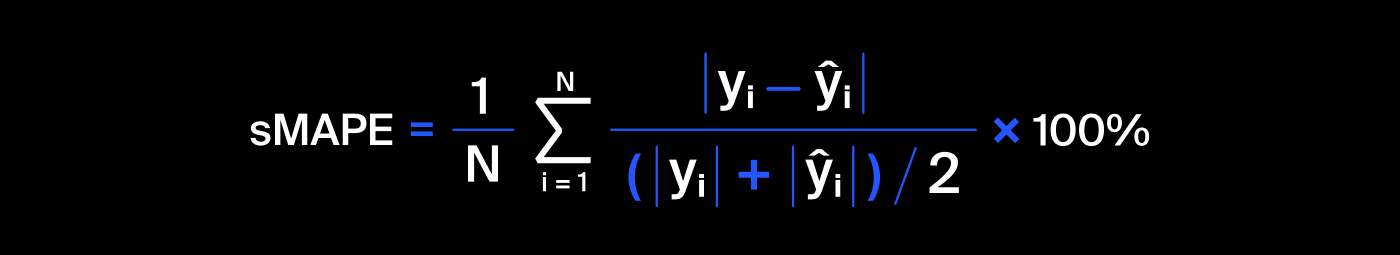

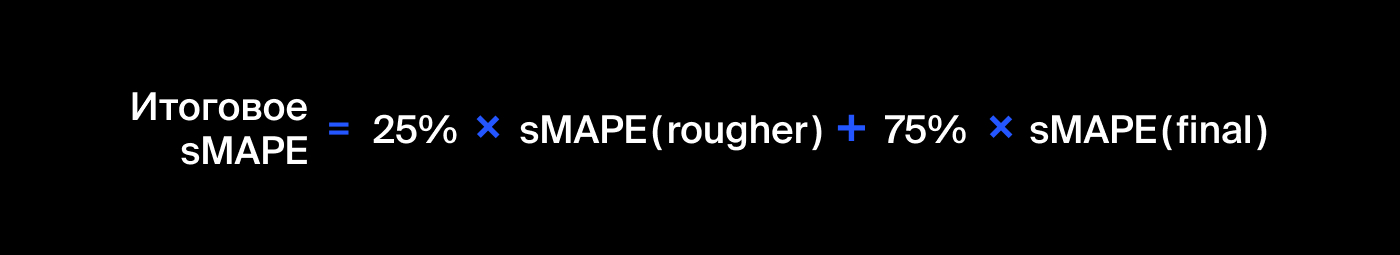

In [38]:
def smape(y_true, y_predict):
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    return (
        0.25
        * (
            (np.abs(y_true[:, 0] - y_predict[:, 0]))
            / ((np.abs(y_true[:, 0]) + np.abs(y_predict[:, 0])) / 2)
        ).mean()
        * 100
    ) + (
        0.75
        * (
            (np.abs(y_true[:, 1] - y_predict[:, 1]))
            / ((np.abs(y_true[:, 1]) + np.abs(y_predict[:, 1])) / 2)
        ).mean()
        * 100
    )


smape_scorer = make_scorer(smape, greater_is_better=False)

В нашем тестовом датасэте отсутствуют целевые признаки. Добавим их из полного датасэта, использовав в качестве индексов признак date.

In [39]:
gold_recovery_test_cleared[
    ["rougher.output.recovery", "final.output.recovery"]
] = gold_recovery_full.loc[
    gold_recovery_test_cleared.index,
    ["rougher.output.recovery", "final.output.recovery"],
]

Создадим датафрэймы с обучающими и целевыми признаками. В качестве целевых признаков мы можем одновременно использовать столбцы 'rougher.output.recovery', 'final.output.recovery'. Также необходимо в X_train оставить только те признаки, которые имеются в X_test

In [40]:
X_test = gold_recovery_test_cleared.drop(
    ["rougher.output.recovery", "final.output.recovery"], axis=1
)
y_test = gold_recovery_test_cleared[
    ["rougher.output.recovery", "final.output.recovery"]
]

X_train = gold_recovery_train_cleared.loc[:, X_test.columns]
y_train = gold_recovery_train_cleared[
    ["rougher.output.recovery", "final.output.recovery"]
]

Создадим сетку параметров. Наилучшие варианты преобразований данных будут подобраны с помощью GridSearchCV.

In [41]:
param_grid = [
    {
        "preprocessor__scaler": [
            StandardScaler(),
            RobustScaler(),
            MinMaxScaler(feature_range=(0, 1)),
        ]
    },
    {
        "preprocessor__scaler": [
            StandardScaler(),
            RobustScaler(),
            MinMaxScaler(feature_range=(0, 1)),
        ],
        "preprocessor__feature_selection": [PCA()],
    },
    {
        "preprocessor__scaler": [
            StandardScaler(),
            RobustScaler(),
            MinMaxScaler(feature_range=(0, 1)),
        ],
        "preprocessor__feature_selection": [RFE],
    },
]

In [36]:
classifiers = [
    LinearRegression(n_jobs=-1),
    DecisionTreeRegressor(random_state=12345),
    ExtraTreesRegressor(
        n_estimators=50, max_depth=20, bootstrap=True, random_state=12345
    ),
    RandomForestRegressor(
        n_estimators=50, max_depth=20, bootstrap=True, random_state=12345
    ),
]

In [38]:
for classifier in classifiers:
    preprocessor = Pipeline(
        steps=[("scaler", "passthrough"), ("feature_selection", "passthrough")]
    )
    classifier = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", classifier),]
    )
    grid_search = GridSearchCV(
        classifier, param_grid=param_grid, cv=5, scoring=smape_scorer, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    y_pred = grid_search.predict(X_test)

    print(f"Итоговое sMAPE: {smape(y_test, y_pred)}")
    print(
        f"Для улучшения модели использовались следующие параметры: {best_params}",
        end="\n\n",
    )

Итоговое sMAPE: 10.398303722620096
Для улучшения модели использовались следующие параметры: {'preprocessor__scaler': StandardScaler()}

Итоговое sMAPE: 18.673878526301685
Для улучшения модели использовались следующие параметры: {'preprocessor__scaler': RobustScaler()}

Итоговое sMAPE: 10.474849572178744
Для улучшения модели использовались следующие параметры: {'preprocessor__scaler': MinMaxScaler()}

Итоговое sMAPE: 11.343709362609967
Для улучшения модели использовались следующие параметры: {'preprocessor__scaler': RobustScaler()}



Сравним модель со случайной с помощью DummyRegressor, где в качестве предсказаний будут использоваться средние значения

In [39]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_test)
smape(y_test, dummy_pred)

11.050198597808166

Мы получили, что модели работают эффективнее, чем случайная модель. Наилучший результат мы получили за счет применения модели линейной регрессии, значение метрики составило 10,4, что ближе всего к 0.

## Вывод

Нам удалось проанализировать данные, а также построить модель, которая предсказывает значения лучше, чем случайная модель.